In [1]:
!cd

c:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE


In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy


In [3]:
# os.chdir('/Users/evanli/Documents/Research_datasets/PBMC_Hao')
adata_raw = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
# adata_raw = sc.read_h5ad('/home/jovyan/work/Research_datasets/GSE164378/Hao_PBMC_GSE164378.h5ad')
print(adata_raw.shape)  # row is cells, column is gene
# (161764, 20568)
# (161764, 33538)

(161764, 33538)


In [5]:
# CPM
# Total-count normalize the data matrix X to 10,000 reads per cell
# sc.pp.normalize_total(adata_raw, target_sum=1e6)

# Log
sc.pp.log1p(adata_raw)

In [6]:
# view adata.X
rows, cols = adata_raw.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_raw.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.945910096168518


In [7]:
# assuming data.X is your sparse CSR matrix
num_nonzero = adata_raw.X.getnnz(axis=1)  # number of nonzeros for each row
num_nonzero[:10]

array([2915, 1617, 1381, 1890, 1621, 1633, 2672, 1122, 1375, 1200],
      dtype=int64)

In [8]:
# All level 1 celltypes
types = np.unique(adata_raw.obs['celltype.l2']).tolist()
print(types)
# cell count in each celltype
adata_raw.obs['celltype.l2'].value_counts()

['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD14 Mono', 'CD16 Mono', 'CD4 CTL', 'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating', 'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


celltype.l2
CD14 Mono            42690
CD4 Naive            17479
NK                   17173
CD4 TCM              14889
CD8 TEM              11727
CD8 Naive            10768
B naive               7718
CD16 Mono             6320
CD4 TEM               4282
gdT                   3649
B memory              3285
CD8 TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B intermediate        2431
Platelet              2293
CD4 CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4 Proliferating      108
CD8 Proliferating       91
Eryth                   83
ASDC                    76
Name: count, dtype: int64

## UMAP

In [9]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata_raw.uns:
    del adata_raw.uns['neighbors']

In [10]:
# PCA
sc.tl.pca(adata_raw, svd_solver='arpack')

# Neighborhood graph
sc.pp.neighbors(adata_raw, n_neighbors=15, n_pcs=40)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import seaborn as sns
import random

palette = sns.color_palette('husl', n_colors=len(types))
# random.shuffle(palette)
palette


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9694404921011296, 0.4533139192955799, 0.4129935154370697),
 (0.9616893970663715, 0.4725037373603897, 0.19646890696034164),
 (0.8692147298460546, 0.5322739253130206, 0.19555868056093095),
 (0.8010662589060259, 0.5671015957062298, 0.19496184258054847),
 (0.7439905369483727, 0.5917280543756063, 0.19450918385560456),
 (0.6909917590738546, 0.6115185492940716, 0.19412657296968922),
 (0.636856168581953, 0.6290950431263406, 0.19377242205025205),
 (0.5757333861726844, 0.6461359149833609, 0.19341596838222402),
 (0.49770828876022927, 0.6641180560980573, 0.1930256236361647),
 (0.37682892388713346, 0.684874356531469, 0.19255662260557546),
 (0.19421317756243572, 0.700455270825837, 0.28680953887039534),
 (0.19960152935535774, 0.693108880099574, 0.44300511352072164),
 (0.20340841315398317, 0.6877217960427562, 0.5232018612747832),
 (0.20645665188886758, 0.6832865022933483, 0.5786241089158312),
 (0.20915074375132892, 0.6792737449369987, 0.6231466279492516),
 (0.21174742527003987, 0.6753215681196512, 0.6630284051859072),
 (0.2144678559918755, 0.6710898032434739, 0.7022520993982322),
 (0.21757872353184043, 0.6661331332974837, 0.7444887466168532),
 (0.22151357260665344, 0.659678039539791, 0.7946672505377085),
 (0.22717940544793624, 0.6500031196478395, 0.8618965635305819),
 (0.2634412723709102, 0.6312155603431547, 0.9586802899654455),
 (0.48340284836598796, 0.5959711995567712, 0.9584916681838017),
 (0.614395386878012, 0.5594926179987361, 0.9583108936692298),
 (0.720573096431553, 0.5179742739042518, 0.9581226213977453),
 (0.8206159702906209, 0.4650337220304159, 0.9579087741969184),
 (0.9269822863314263, 0.3855354815124441, 0.9576405689327391),
 (0.9600390619134246, 0.3783314591449851, 0.8800858248652649),
 (0.9624873221120426, 0.399446711476271, 0.7926307757488626),
 (0.9644083124987776, 0.4151458714664657, 0.7136833241341359),
 (0.9660772584989742, 0.428244318341574, 0.634249439494473)]

In [ ]:
# UMAP

sc.tl.umap(adata_raw)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


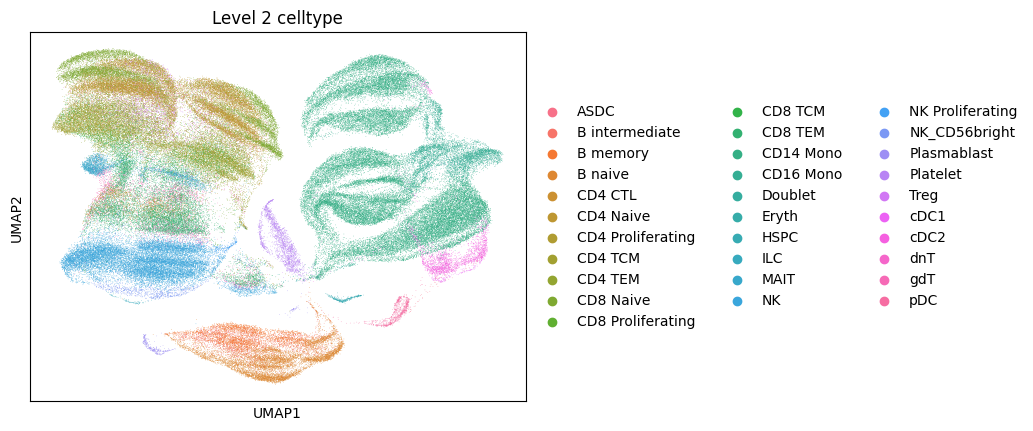

In [25]:
sc.pl.umap(adata_raw, color='celltype.l2', title='Level 2 celltype', palette=palette)

In [26]:
# Leiden clustering
sc.tl.leiden(adata_raw)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


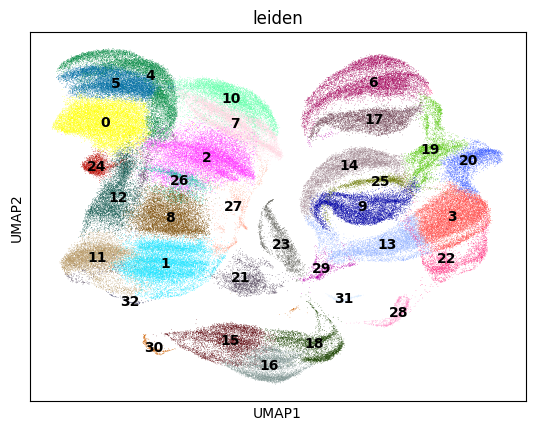

In [27]:
# Plot Leiden
sc.pl.umap(adata_raw, color='leiden', legend_loc="on data")

## Representative cells
Select top 20% clustering coefficient cells in each cell type

In [28]:
umap_adja_matrix = adata_raw.obsp['connectivities']
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3423620 stored elements in Compressed Sparse Row format>

In [29]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1711810 edges
161764


In [30]:
adata_raw.obs.columns

Index(['celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'donor',
       'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'leiden'],
      dtype='object')

In [31]:
# Select top 20% clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    # select cells from one celltype
    celltype_idx = np.where(adata_raw.obs['celltype.l2'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top20_count = int(len(celltype_coeff) * 0.2)
    top20_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top20_count]
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top20_indices}
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))

ASDC 15
B intermediate 486
B memory 657
B naive 1543
CD14 Mono 8538
CD16 Mono 1264
CD4 CTL 347
CD4 Naive 3495
CD4 Proliferating 21
CD4 TCM 2977
CD4 TEM 856
CD8 Naive 2153
CD8 Proliferating 18
CD8 TCM 576
CD8 TEM 2345
Doublet 121
Eryth 16
HSPC 65
ILC 26
MAIT 556
NK 3434
NK Proliferating 109
NK_CD56bright 188
Plasmablast 73
Platelet 458
Treg 501
cDC1 30
cDC2 500
dnT 71
gdT 729
pDC 172


In [32]:
len(alltype_selected)

32340

In [33]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata_raw.obs['is_representative'] = is_representative
# adata_raw.obs.head()

In [34]:
sum(adata_raw.obs['is_representative'] == 'Yes')

32340

In [35]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata_raw.shape[0]):
    if adata_raw.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata_raw.obs['is_representative'][i] + '_' + adata_raw.obs['celltype.l2'][i])
    else:
        # No
        clus_rep.append(adata_raw.obs['is_representative'][i])

adata_raw.obs['cluster_representative'] = clus_rep

C:\Users\evanlee\AppData\Local\Temp\ipykernel_10556\2548769488.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_raw.obs['is_representative'][i] == 'Yes':
C:\Users\evanlee\AppData\Local\Temp\ipykernel_10556\2548769488.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clus_rep.append(adata_raw.obs['is_representative'][i])
C:\Users\evanlee\AppData\Local\Temp\ipykernel_10556\2548769488.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [36]:
adata_raw.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,3,No,No
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,0,No,No
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,5,No,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,11,No,No
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,5,No,No


## Plot representative cell UMAP

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


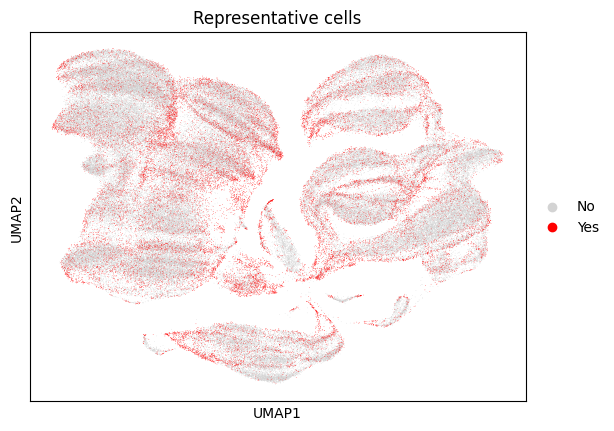

In [37]:
# Plot Yes/No representative cells
sc.pl.umap(adata_raw, color='is_representative', title='Representative cells', palette=['#D3D3D3', 'red'])

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


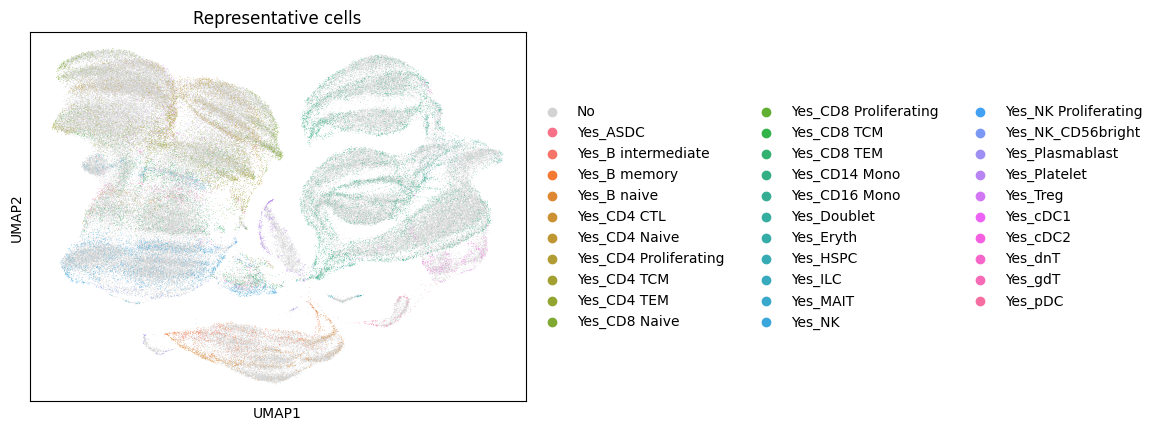

In [38]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata_raw, color='cluster_representative', title='Representative cells', palette=['#D3D3D3']+palette)  #, palette= ['#D3D3D3'] + palette

## Export representative cells adata

In [39]:
# view adata.X
rows, cols = adata_raw.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_raw.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.945910096168518


In [40]:
!cd

c:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE


In [41]:
# replace level1 and level2 celltype names with new names
# replace " " with "_"

# level1
level1 = adata_raw.obs['celltype.l1'].tolist()
level1 = [x.replace(" ", "_") for x in level1]
level1 = np.array(level1)
adata_raw.obs['celltype.l1'] = level1

# level2
level2 = adata_raw.obs['celltype.l2'].tolist()
level2 = [x.replace(" ", "_") for x in level2]
level2 = np.array(level2)
adata_raw.obs['celltype.l2'] = level2


In [42]:
np.unique(adata_raw.obs['celltype.l1']).tolist()

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [43]:
np.unique(adata_raw.obs['celltype.l2']).tolist()

['ASDC',
 'B_intermediate',
 'B_memory',
 'B_naive',
 'CD14_Mono',
 'CD16_Mono',
 'CD4_CTL',
 'CD4_Naive',
 'CD4_Proliferating',
 'CD4_TCM',
 'CD4_TEM',
 'CD8_Naive',
 'CD8_Proliferating',
 'CD8_TCM',
 'CD8_TEM',
 'Doublet',
 'Eryth',
 'HSPC',
 'ILC',
 'MAIT',
 'NK',
 'NK_CD56bright',
 'NK_Proliferating',
 'Plasmablast',
 'Platelet',
 'Treg',
 'cDC1',
 'cDC2',
 'dnT',
 'gdT',
 'pDC']

In [44]:
adata_rep_cells = adata_raw[adata_raw.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(32340, 33538)

In [45]:
# write as new h5ad file
adata_rep_cells.write_h5ad('Hao_PBMC_GSE_level2_rep_cells_onlyLog1p.h5ad')


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Take a look at Hao_PBMC_GSE_level1_rep_cells.h5ad

In [46]:
data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE_level2_rep_cells_onlyLog1p.h5ad")
data.shape

(32340, 33538)

In [47]:
# view adata.X
rows, cols = data.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {data.X[row, col]}')
    i += 1


Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 71, Value 0.6931471824645996
Row 0, Column 72, Value 0.6931471824645996
Row 0, Column 93, Value 1.6094379425048828
Row 0, Column 100, Value 0.6931471824645996
Row 0, Column 152, Value 0.6931471824645996
Row 0, Column 154, Value 2.079441547393799
Row 0, Column 201, Value 0.6931471824645996
Row 0, Column 209, Value 0.6931471824645996
Row 0, Column 219, Value 0.6931471824645996
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 244, Value 0.6931471824645996
Row 0, Column 245, Value 0.6931471824645996
Row 0, Column 271, Value 0.6931471824645996
Row 0, Column 315, Value 1.0986123085021973
Row 0, Column 335, Value 0.6931471824645996
Row 0, Column 363, Value 0.6931471824645996
Row 0, Column 390, Value 1.0986123085021973
Row 0, Column 408, Value 1.0986123085021973
Row 0, Column 412, Value 1.0986123085021973


In [49]:
data.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCACATCAGTCA,CD8_T,CD8_TEM,CD8 TEM_1,G1,Batch1,P3,5297,212,4332,1633,12,Yes,Yes_CD8 TEM
L1_AAACGAACAATGAGCG,CD4_T,CD4_TCM,CD4 TCM_2,G1,Batch1,P1,5465,211,7379,2315,27,Yes,Yes_CD4 TCM
L1_AAACGAACAGCTACTA,NK,NK,NK_2,G1,Batch1,P4,3161,211,1538,822,21,Yes,Yes_NK
L1_AAACGCTAGGTCGTCC,CD8_T,CD8_TEM,CD8 TEM_2,S,Batch1,P1,7332,208,5120,1688,12,Yes,Yes_CD8 TEM
L1_AAACGCTCAACGATCT,CD8_T,CD8_TCM,CD8 TCM_1,S,Batch1,P3,4665,205,4593,1435,0,Yes,Yes_CD8 TCM
